In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
# -------------------
# Load and preprocess data
# -------------------

In [11]:
# RUN PREPROCESSING AND THEN CAN RUN EITHER CROSS VALIDATION OR REGULAR TRAINING

#df = pd.read_csv("/Users/tobitlouis/Desktop/Data/individual_book_train/stock_0.csv")
df = pd.read_csv("/Users/tobitlouis/Desktop/Data//S27FE-10K.csv")



In [12]:

def make_features(df: pd.DataFrame) -> pd.DataFrame:
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice
    with np.errstate(divide='ignore', invalid='ignore'):
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den > 0, num / den, np.nan)

        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2 > 0, num2 / den2, np.nan)

        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den > 0, num3 / den, np.nan)

    # 3. normalized_spread & L2 OBI
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(den2 > 0, (df['bid_size1'] + df['bid_size2']) / den2, np.nan)

    # 4. LOB entropy
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p = np.divide(sizes, total, where=total != 0)
    entropy = -np.nansum(np.where(p > 0, p * np.log(p), 0), axis=1)
    df['LOB_entropy'] = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)

    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 6. Realized volatility (safe: no leakage)
    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: np.sqrt((x.shift(1) ** 2)
                                       .rolling(window=30, min_periods=1).sum()))
    )

    df['rv_future'] = (
        df.groupby('time_id')['realized_volatility'].shift(-60)   
    )

    # 7. Bipower variance (safe: no leakage)
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.abs().shift(1)
                       .rolling(2, min_periods=1)
                       .apply(lambda r: r[0] * r[1], raw=True)
                       .rolling(30, min_periods=1)
                       .mean())
    )

    # 8. WAP and its log return
    df['wap'] = (
        (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) /
        (df['bid_size1'] + df['ask_size1']).replace(0, np.nan)
    )
    df['log_wap_return'] = (
        df.groupby('time_id')['wap']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 9. Lag features (safe)
    for col in ['imbalance', 'book_pressure', 'log_return']:
        df[f'{col}_lag1'] = df.groupby('time_id')[col].shift(1)
        df[f'{col}_lag2'] = df.groupby('time_id')[col].shift(2)

    # 10. Rolling stats (safe)
    df['rolling_vol_30'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).std())
    )
    df['rolling_imbalance_mean_30'] = (
        df.groupby('time_id')['imbalance']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).mean())
    )

    df = df.dropna(subset=['rv_future'])   
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

In [13]:

df = make_features(df)

/var/folders/1x/1h6q844j3q17xnp4kqxpsnz00000gn/T/ipykernel_72889/1733880287.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


In [14]:

feature_cols = [
    'seconds_in_bucket',        
    'mid_price',
    'spread',
    'imbalance', 'imbalance_lag1', 'imbalance_lag2',
    'book_pressure', 'book_pressure_lag1', 'book_pressure_lag2',
    'microprice',
    'normalized_spread',
    'OBI_L2',
    'LOB_entropy', 'LOB_entropy_normalized',
    'log_return', 'log_return_lag1', 'log_return_lag2',
    'bipower_var',
    'wap', 'log_wap_return',
    'rolling_vol_30',
    'rolling_imbalance_mean_30',
    #'realized_volatility'
]
target_col = 'rv_future'

In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ————————————————————————————————————————————————————————
# 1) PRE-PROCESSING (unchanged)
# ————————————————————————————————————————————————————————

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

X = df[feature_cols].values
y = df[target_col].values

y_log  = np.log1p(y)
y_mean = y_log.mean()
y_std  = y_log.std()
y_scaled = (y_log - y_mean) / y_std

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)

class WindowDataset(Dataset):
    def __init__(self, X, y, w): self.X,self.y,self.w = X,y,w
    def __len__(self): return len(self.X)-self.w
    def __getitem__(self,i):
        return (
          torch.tensor(self.X[i:i+self.w],dtype=torch.float32),
          torch.tensor(self.y[i+self.w],dtype=torch.float32),
        )

window_size = 30
dataset     = WindowDataset(X_scaled, y_scaled, window_size)
n_train     = int(len(dataset)*0.8)
n_test      = len(dataset)-n_train
train_ds, test_ds = random_split(dataset, [n_train, n_test])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(test_ds, batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ————————————————————————————————————————————————————————
# 2) MODEL with Dropout
# ————————————————————————————————————————————————————————

class CNNLSTMVolatility(nn.Module):
    def __init__(self, num_features,
                 cnn_channels=[32,64],
                 lstm_hidden=64,
                 lstm_layers=1,
                 dropout=0.1):
        super().__init__()
        # conv blocks with dropout
        self.conv1  = nn.Conv1d(num_features, cnn_channels[0], kernel_size=5, padding=2)
        self.conv2  = nn.Conv1d(cnn_channels[0], cnn_channels[1], kernel_size=3, padding=1)
        self.relu   = nn.ReLU()
        self.do_cnn = nn.Dropout(dropout)

        # LSTM
        self.lstm = nn.LSTM(input_size=cnn_channels[1],
                            hidden_size=lstm_hidden,
                            num_layers=lstm_layers,
                            batch_first=True,
                            dropout=0.0)

        # head with dropout
        self.fc1    = nn.Linear(lstm_hidden, lstm_hidden//2)
        self.do_head= nn.Dropout(dropout)
        self.fc2    = nn.Linear(lstm_hidden//2, 1)

    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.do_cnn(self.relu(self.conv1(x)))
        x = self.do_cnn(self.relu(self.conv2(x)))
        x = x.permute(0,2,1)

        out, _ = self.lstm(x)
        last   = out[:, -1, :]

        h = self.do_head(self.relu(self.fc1(last)))
        return self.fc2(h).squeeze()

model = CNNLSTMVolatility(num_features=X_scaled.shape[1]).to(device)

# ————————————————————————————————————————————————————————
# 3) OPTIMIZER with weight_decay + Early Stopping
# ————————————————————————————————————————————————————————

optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-4)    # L2 regularization

criterion = nn.MSELoss()

best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # --- train ---
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # --- validate ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch:03d}  Train: {train_loss:.6f}  Val: {val_loss:.6f}")

    # --- early stopping check ---
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

# reload best
model.load_state_dict(torch.load("best_model.pt"))

# ————————————————————————————————————————————————————————
# 4) FINAL EVAL
# ————————————————————————————————————————————————————————

model.eval()
preds_s, trues_s = [], []
with torch.no_grad():
    for xb, yb in val_loader:  # using the original test split
        xb = xb.to(device)
        out = model(xb).cpu().numpy()
        preds_s.extend(out)
        trues_s.extend(yb.numpy())

preds_s = np.array(preds_s)
trues_s = np.array(trues_s)
pred_log = preds_s * y_std + y_mean
true_log = trues_s * y_std + y_mean
pred_orig= np.expm1(pred_log)
true_orig= np.expm1(true_log)

def qlike_safe(actual, forecast, eps=1e-8):
    a = np.clip(actual,   eps, None)
    f = np.clip(forecast, eps, None)
    r = a / f
    return np.mean(r - np.log(r) - 1.0)

ql = qlike_safe(trues_s, preds_s)


mse    = mean_squared_error(true_orig, pred_orig)
var_y  = np.var(true_orig)
rel_mse= mse/var_y
r2     = r2_score(true_orig, pred_orig)

print(f"\nFinal Evaluation:")
print(f"  MSE:       {mse:.8f}")
print(f"  Var(y):    {var_y:.8f}")
print(f"  Rel.MSE:   {rel_mse:.4f}")
print(f"  R²:        {r2:.4f}")
print("QLIKE:", ql)

Epoch 001  Train: 0.607113  Val: 0.481048
Epoch 002  Train: 0.464053  Val: 0.407005
Epoch 003  Train: 0.381217  Val: 0.304612
Epoch 004  Train: 0.305249  Val: 0.262712
Epoch 005  Train: 0.250004  Val: 0.203216
Epoch 006  Train: 0.268286  Val: 0.257382
Epoch 007  Train: 0.234977  Val: 0.233435
Epoch 008  Train: 0.212760  Val: 0.171993
Epoch 009  Train: 0.183872  Val: 0.163664
Epoch 010  Train: 0.162465  Val: 0.186162
Epoch 011  Train: 0.160058  Val: 0.139094
Epoch 012  Train: 0.137976  Val: 0.142104
Epoch 013  Train: 0.124400  Val: 0.119454
Epoch 014  Train: 0.116697  Val: 0.112711
Epoch 015  Train: 0.107649  Val: 0.100669
Epoch 016  Train: 0.108775  Val: 0.103057
Epoch 017  Train: 0.105207  Val: 0.097796
Epoch 018  Train: 0.094173  Val: 0.096853
Epoch 019  Train: 0.090640  Val: 0.082830
Epoch 020  Train: 0.083818  Val: 0.078134
Epoch 021  Train: 0.091380  Val: 0.091146
Epoch 022  Train: 0.088587  Val: 0.075725
Epoch 023  Train: 0.080773  Val: 0.073056
Epoch 024  Train: 0.074047  Val: 0

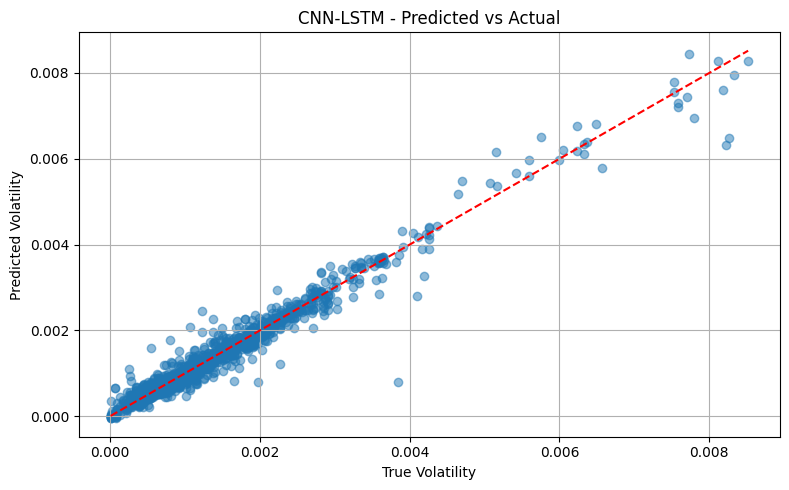

  R²:        0.9635


In [16]:
# -------------------
# Plot predictions
# -------------------

plt.figure(figsize=(8, 5))
plt.scatter(true_orig, pred_orig, alpha=0.5)
plt.plot([min(true_orig), max(true_orig)], [min(true_orig), max(true_orig)], 'r--')
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.title("CNN-LSTM - Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()
print(f"  R²:        {r2:.4f}")

In [17]:
from sklearn.model_selection import GroupKFold
from torch.utils.data import Subset
import matplotlib.pyplot as plt

# ——————————————————————
# Prepare groups array
# ——————————————————————
# `df` is your preprocessed DataFrame (with make_features applied, NaNs dropped, etc.)
time_ids = df['time_id'].values

# When we build windows of length `window_size`, the label at window i is from df index (i + window_size)
window_size = 30
group_labels = time_ids[window_size:]  # length = n_rows - window_size

# Build the dataset on the full scaled arrays
full_dataset = WindowDataset(X_scaled, y_scaled, window_size)
n = len(full_dataset)

# ——————————————————————
# Use GroupKFold instead of KFold
# ——————————————————————
gkf = GroupKFold(n_splits=5)

r2_scores, mse_scores = [], []

for fold, (train_idx, val_idx) in enumerate(
        gkf.split(X=np.empty(n), y=np.empty(n), groups=group_labels),
        start=1):
    print(f"\nFold {fold}/5")

    # Subset for this fold
    train_ds = Subset(full_dataset, train_idx)
    val_ds   = Subset(full_dataset, val_idx)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False)

    # Fresh model each fold
    model     = CNNLSTMVolatility(num_features=X_scaled.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Train
    for epoch in range(20):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    # Validate
    model.eval()
    preds_s, trues_s = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            out = model(xb).cpu().numpy()
            preds_s.extend(out)
            trues_s.extend(yb.numpy())

    # Invert the standard‐scale + log1p
    preds_s = np.array(preds_s)
    trues_s = np.array(trues_s)
    pred_log = preds_s * y_std + y_mean
    true_log = trues_s * y_std + y_mean
    pred_orig = np.expm1(pred_log)
    true_orig = np.expm1(true_log)

    mse = mean_squared_error(true_orig, pred_orig)
    r2  = r2_score(true_orig, pred_orig)
    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"  MSE: {mse:.6f}, R²: {r2:.4f}")

# ——————————————————————
# Summary
# ——————————————————————
print("\n✅ Group‐aware Cross‐Validation Summary:")
print(f"  Avg MSE: {np.mean(mse_scores):.6f} ± {np.std(mse_scores):.6f}")
print(f"  Avg R²:  {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")



Fold 1/5
  MSE: 0.000001, R²: -1.2050

Fold 2/5
  MSE: 0.000001, R²: 0.2048

Fold 3/5
  MSE: 0.000003, R²: -0.0076

Fold 4/5
  MSE: 0.000001, R²: 0.1288

Fold 5/5
  MSE: 0.000001, R²: -0.2643

✅ Group‐aware Cross‐Validation Summary:
  Avg MSE: 0.000001 ± 0.000001
  Avg R²:  -0.2287 ± 0.5136
